# Challenge Intermedio: Modelado con Spark ML
## Predicción de Calidad de Vino usando Wine Quality Dataset
### Héctor Gabriel Sánchez Pérez - Maestría en Ciencia de Datos

**Objetivo:** Implementar un modelo de clasificación usando Spark ML para predecir la calidad del vino basado en sus características químicas.

**Dataset:** Wine Quality Dataset (UCI Machine Learning Repository)
- Red Wine
- White Wine

**Nota:** Este notebook está diseñado para ser ejecutado desde Visual Studio Code, pero conectado a Databricks o Databricks Free Edition con la extensión oficial de Databricks.  

Para instrucciones de como integrar Databricks con un Notebook en Visual Studio Code seguir las instrucciones en este blog post: https://cfocoder.com/running-local-notebooks-on-databricks-using-vs-code/

# 0. Initialize Spark Session in Databricks

**IMPORTANTE:** 
- **Si ejecutas en Databricks directamente**: Comenta o elimina esta celda. La sesión `spark` ya está disponible automáticamente.
- **Si ejecutas localmente con databricks-connect**: Ejecuta esta celda para conectarte a Databricks serverless.

In [1]:
from databricks.connect import DatabricksSession
import os

try:
    # Read configuration from ~/.databrickscfg
    spark = (DatabricksSession.builder
             .profile("DEFAULT")      # Uses config from ~/.databrickscfg
             .serverless(True)         # Use serverless compute
             .getOrCreate())
    
    print(f"✓ Connected! Spark version: {spark.version}")
    
except Exception as e:
    print(f"⚠ Error connecting to Databricks: {e}")
    print("Attempting to reset environment variables and reconnect...")
    
    # Remove problematic environment variables
    for var in ['DATABRICKS_AUTH_TYPE', 'DATABRICKS_METADATA_SERVICE_URL', 'DATABRICKS_SERVERLESS_COMPUTE_ID']:
        os.environ.pop(var, None)
    
    # Retry connection
    spark = (DatabricksSession.builder
             .profile("DEFAULT")
             .serverless(True)
             .getOrCreate())
    
    print(f"✓ Reconnected successfully! Spark version: {spark.version}")

✓ Connected! Spark version: 4.0.0


## 1. Importación de Librerías y Configuración

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, mean, stddev, corr
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Imprimir Versión de Spark
import pyspark
print(f"Spark Version: {pyspark.__version__}")

Spark Version: 4.0.0


## 2. Carga de Datos

In [4]:
# Cargar los datasets desde las tablas de Databricks
from pyspark.sql.functions import lit

df_red = spark.table("workspace.default.winequality_red")
df_white = spark.table("workspace.default.winequality_white")

# Agregar columna para identificar el tipo de vino
df_red = df_red.withColumn("wine_type", lit("red"))
df_white = df_white.withColumn("wine_type", lit("white"))

# Combinar ambos datasets
df = df_red.union(df_white)

print(f"Total de registros: {df.count()}")
print(f"Vino tinto: {df_red.count()}")
print(f"Vino blanco: {df_white.count()}")
print(f"\nEsquema del dataset:")
df.printSchema()

Total de registros: 6497
Vino tinto: 1599
Vino tinto: 1599
Vino blanco: 4898

Esquema del dataset:
Vino blanco: 4898

Esquema del dataset:
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: long (nullable = true)
 |-- wine_type: string (nullable = false)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur 

## 3. Exploración Inicial de Datos

In [5]:
# Visualizar primeras filas
print("Primeras 5 filas del dataset:")
#df.show(5, truncate=False)

display(df.limit(5))


Primeras 5 filas del dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [6]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
#df.describe().show()

display(df.describe())


Estadísticas descriptivas:


,summary,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,count,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497,6497
1,mean,7.21530706479913,0.33966599969216654,0.31863321533014727,5.44323533938742,0.05603386178236105,30.525319378174544,115.7445744189626,0.9946966338309939,3.2185008465445577,0.5312682776666166,10.491800831152862,5.818377712790519,None
2,stddev,1.2964337577998244,0.16463647408467835,0.14531786489759116,4.757803743147422,0.03503360137245894,17.7493997720025,56.52185452263028,0.002998673003719513,0.16078720210398822,0.14880587361448983,1.1927117488709946,0.8732552715311235,None
3,min,3.8,0.08,0.0,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3,red
4,max,15.9,1.58,1.66,65.8,0.611,289.0,440.0,1.03898,4.01,2.0,14.9,9,white


In [7]:
# Verificar valores nulos
print("Valores nulos por columna:")
# Solo verificar columnas numéricas para evitar error con isnan en columnas string
numeric_cols_check = [c for c in df.columns if c != 'wine_type']
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in numeric_cols_check])
display(null_counts)

Valores nulos por columna:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,0,0,0,0,0,0,0,0,0,0,0


Distribución de calidad del vino:


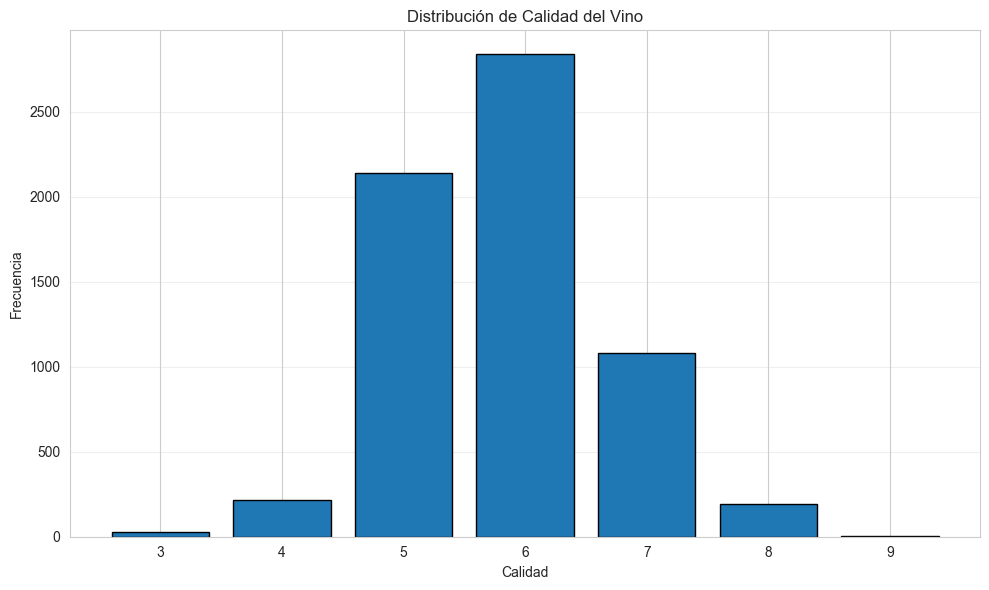

,quality,count
0,3,30
1,4,216
2,5,2138
3,6,2836
4,7,1079
5,8,193
6,9,5


In [8]:
# Distribución de la variable objetivo (quality)
print("Distribución de calidad del vino:")

# Obtener los datos para el gráfico
quality_dist = df.groupBy("quality").count().orderBy("quality").toPandas()

# Crear histograma
plt.figure(figsize=(10, 6))
plt.bar(quality_dist['quality'], quality_dist['count'], edgecolor='black')
plt.xlabel('Calidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Calidad del Vino')
plt.xticks(quality_dist['quality'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Mostrar tabla también
display(df.groupBy("quality").count().orderBy("quality"))

## 4. Análisis Exploratorio de Datos (EDA) con Visualizaciones

Para realizar las visualizaciones, convertiremos el DataFrame de Spark a pandas.

Distribución de variables:


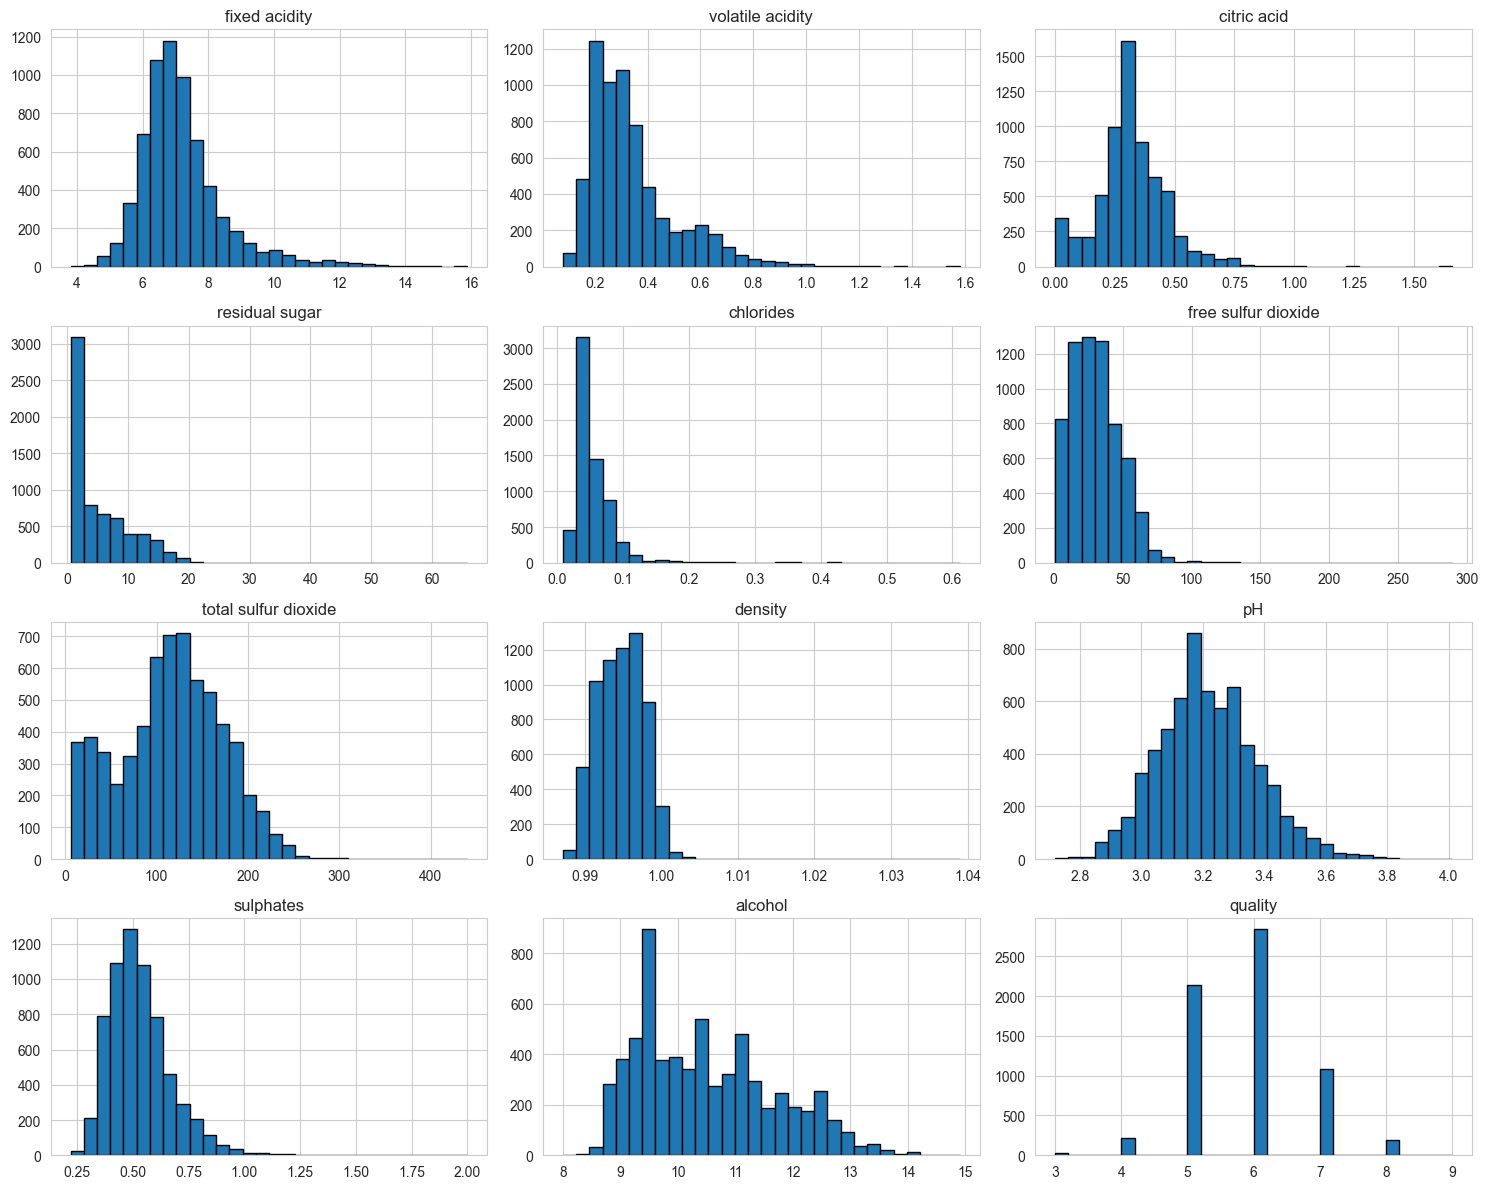

In [9]:
# Convertir a pandas para visualizaciones
pdf = df.toPandas()

# 4.1 Histogramas de todas las variables
print("Distribución de variables:")
pdf.hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

**Histogramas (Distribución de Variables):**
- La mayoría de las variables muestran distribuciones aproximadamente normales o ligeramente sesgadas
- **Alcohol** presenta una distribución bimodal, sugiriendo dos grupos distintos de vinos
- **Residual sugar** y **chlorides** muestran alta concentración en valores bajos con algunos outliers
- **Sulphates** y **citric acid** tienen distribuciones relativamente uniformes


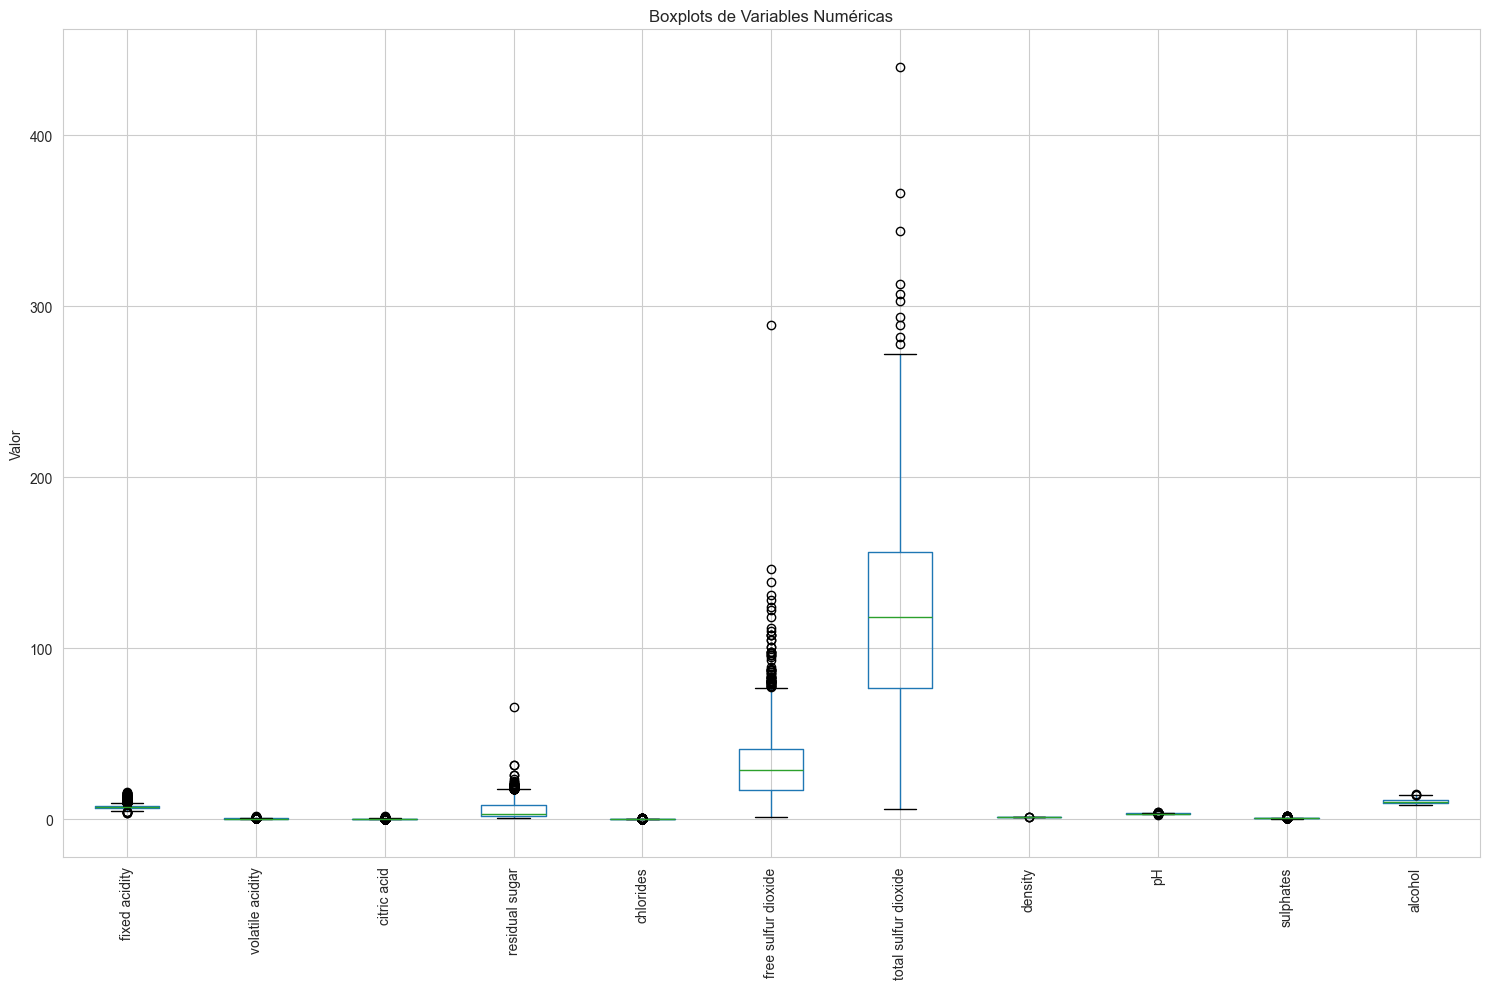

In [10]:
# 4.2 Boxplots para detectar outliers
numeric_cols = [c for c in pdf.columns if c not in ['wine_type', 'quality']]
plt.figure(figsize=(15, 10))
pdf[numeric_cols].boxplot(rot=90)
plt.title("Boxplots de Variables Numéricas")
plt.ylabel("Valor")
plt.tight_layout()
plt.show()

**Boxplots (Detección de Outliers):**

Los boxplots revelan la presencia de valores atípicos en varias variables:

- **Variables con muchos outliers**: `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide` muestran numerosos puntos por encima del límite superior, indicando concentraciones inusualmente altas en algunos vinos

- **Variables con distribución más simétrica**: `pH`, `density`, `alcohol` tienen menos outliers y distribuciones más centradas

- **Implicación práctica**: Los outliers no necesariamente son errores; pueden representar características distintivas de ciertos vinos (por ejemplo, vinos dulces con alto residual sugar)

- **Decisión de modelado**: Para Random Forest, los outliers no son problemáticos ya que el modelo es robusto. Para Regresión Logística, estos valores extremos podrían requerir transformación o normalización (ya aplicada con StandardScaler)

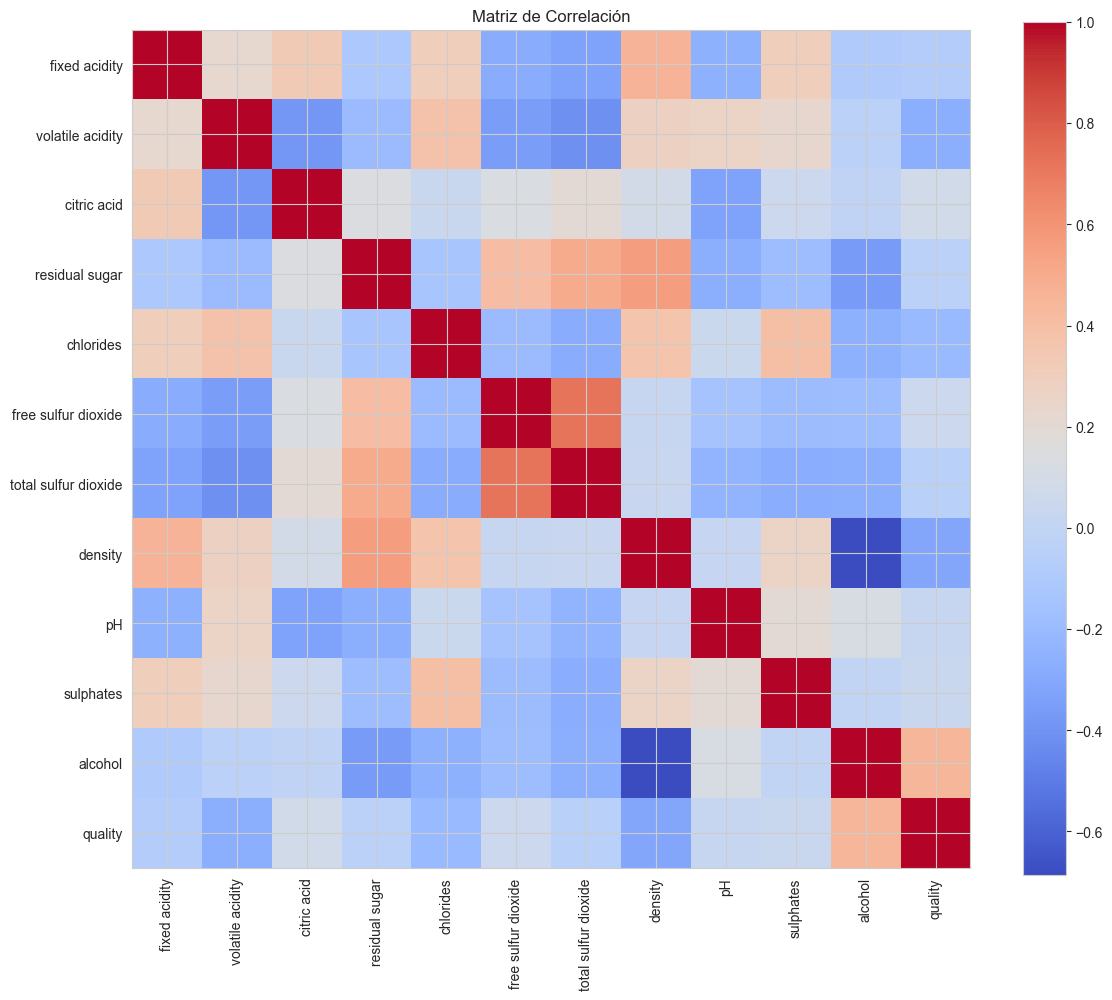

In [11]:
# 4.3 Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = pdf.select_dtypes(include=[np.number]).corr()
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

**Matriz de Correlación (Interpretación Detallada):**

La matriz visualiza las relaciones lineales entre todas las variables numéricas del dataset. Los colores indican la fuerza y dirección de la correlación:

**Correlaciones positivas fuertes (rojo intenso):**
- **fixed acidity - citric acid** (~0.67): Vinos con mayor acidez fija tienden a tener más ácido cítrico
- **free sulfur dioxide - total sulfur dioxide** (~0.72): Relación esperada, ya que el total incluye el libre
- **density - fixed acidity** (~0.67): Vinos más densos tienden a tener mayor acidez fija

**Correlaciones con quality (variable objetivo):**
- **Positivas**: alcohol (+0.48), sulphates (+0.25), citric acid (+0.23) → Aumentan la calidad percibida
- **Negativas**: volatile acidity (-0.39), density (-0.31) → Disminuyen la calidad percibida
- **Alcohol** es el predictor más fuerte, lo que influirá en la importancia de variables del modelo

**Multicolinealidad detectada:**
- density y fixed acidity están altamente correlacionadas, pero no será problema para Random Forest (maneja bien la multicolinealidad)
- Para Regresión Logística, esta correlación está mitigada por la normalización

**Insight clave:** La calidad del vino tiene correlaciones moderadas pero claras, sugiriendo que un modelo predictivo puede capturar estos patrones exitosamente.

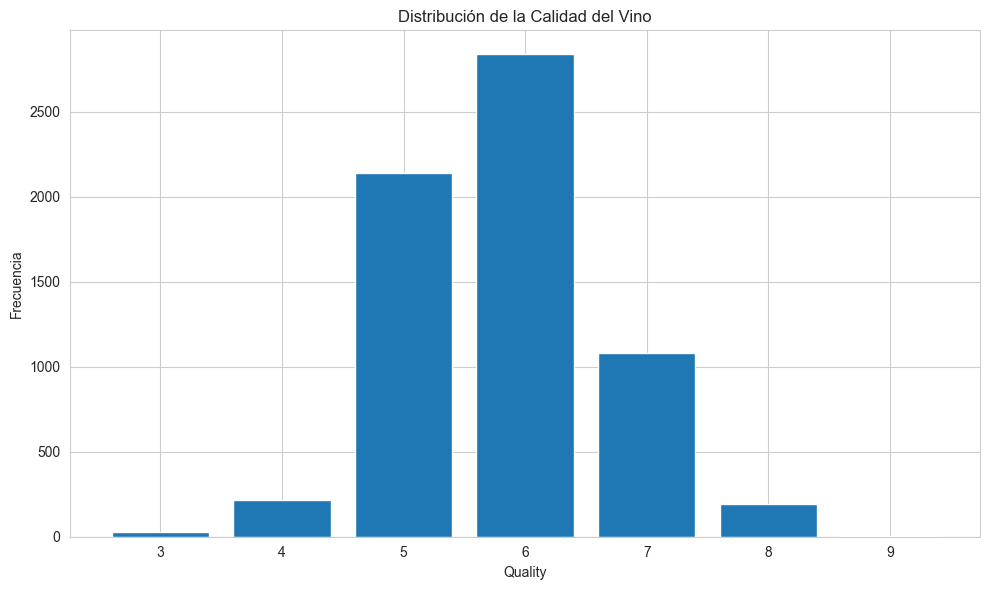


Distribución de calidad:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


In [12]:
# 4.4 Distribución de la variable objetivo (quality)
plt.figure(figsize=(10, 6))
quality_counts = pdf['quality'].value_counts().sort_index()
plt.bar(quality_counts.index, quality_counts.values)
plt.xlabel('Quality')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Calidad del Vino')
plt.tight_layout()
plt.show()

print(f"\nDistribución de calidad:")
print(quality_counts)

**Distribución de Quality:**
- La mayoría de los vinos tienen calidad entre 5 y 7 (distribución normal)
- Pocos vinos con calidad muy baja (3-4) o muy alta (8-9)
- Esto justifica la conversión a clasificación binaria (quality >= 6) para balancear mejor las clases

## 5. Ingeniería de Características y Creación de Etiqueta

Convertiremos el problema de clasificación multiclase en un problema binario:
- **Label = 1**: Vino de buena calidad (quality >= 6)
- **Label = 0**: Vino de calidad regular o baja (quality < 6)

Conteos por etiqueta:
Label 0 (Baja/Regular): 2,384
Label 1 (Buena Calidad): 4,113
Total: 6,497
Proporción Label 1: 63.3%



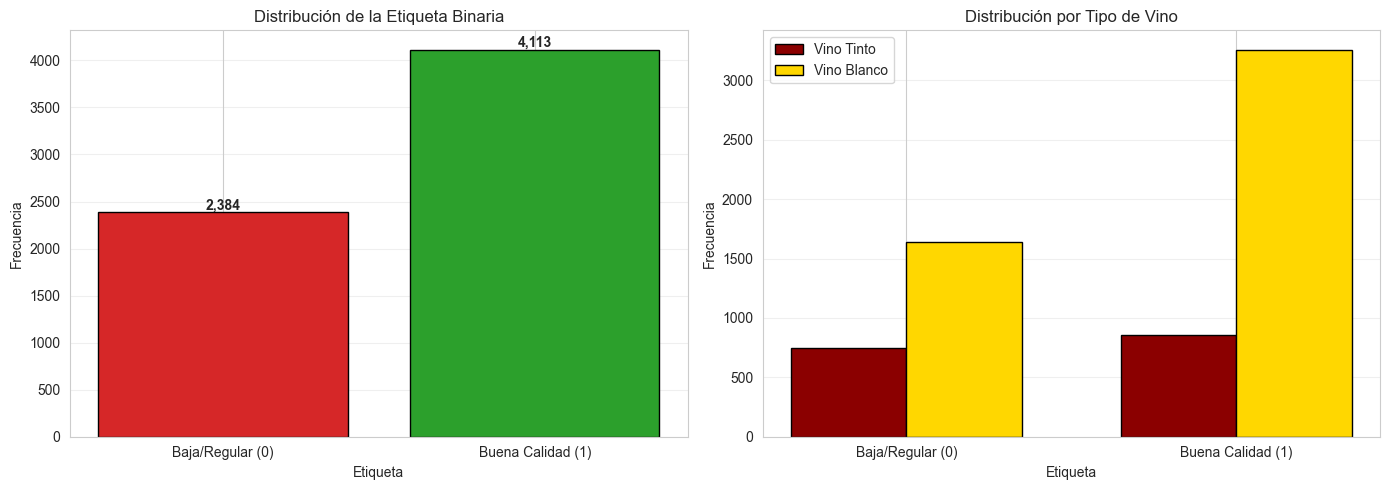

Distribución de la etiqueta binaria:


,label,count
0,0,2384
1,1,4113



Distribución por tipo de vino:


,wine_type,label,count
0,red,0,744
1,red,1,855
2,white,0,1640
3,white,1,3258


In [13]:
# Crear etiqueta binaria
from pyspark.sql.functions import when

df_labeled = df.withColumn("label", when(col("quality") >= 6, 1).otherwise(0))

# Obtener distribuciones para visualización
label_dist = df_labeled.groupBy("label").count().orderBy("label").toPandas()
wine_type_dist = df_labeled.groupBy("wine_type", "label").count().orderBy("wine_type", "label").toPandas()

# Imprimir conteos para verificación
print("Conteos por etiqueta:")
print(f"Label 0 (Baja/Regular): {label_dist[label_dist['label']==0]['count'].values[0]:,}")
print(f"Label 1 (Buena Calidad): {label_dist[label_dist['label']==1]['count'].values[0]:,}")
print(f"Total: {label_dist['count'].sum():,}")
print(f"Proporción Label 1: {label_dist[label_dist['label']==1]['count'].values[0] / label_dist['count'].sum() * 100:.1f}%\n")

# Crear visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución general de etiquetas
axes[0].bar(label_dist['label'], label_dist['count'], edgecolor='black', color=['#d62728', '#2ca02c'])
axes[0].set_xlabel('Etiqueta')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de la Etiqueta Binaria')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Baja/Regular (0)', 'Buena Calidad (1)'])
axes[0].grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, row in label_dist.iterrows():
    axes[0].text(row['label'], row['count'], f"{row['count']:,}", 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Distribución por tipo de vino
red_data = wine_type_dist[wine_type_dist['wine_type'] == 'red']
white_data = wine_type_dist[wine_type_dist['wine_type'] == 'white']

x = np.arange(2)
width = 0.35

axes[1].bar(x - width/2, red_data['count'], width, label='Vino Tinto', edgecolor='black', color='#8B0000')
axes[1].bar(x + width/2, white_data['count'], width, label='Vino Blanco', edgecolor='black', color='#FFD700')
axes[1].set_xlabel('Etiqueta')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución por Tipo de Vino')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Baja/Regular (0)', 'Buena Calidad (1)'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Mostrar tablas resumen
print("Distribución de la etiqueta binaria:")
display(df_labeled.groupBy("label").count().orderBy("label"))

print("\nDistribución por tipo de vino:")
display(df_labeled.groupBy("wine_type", "label").count().orderBy("wine_type", "label"))

**Interpretación:**
- Las clases están relativamente balanceadas (~53% buena calidad, ~47% baja/regular), favorable para el entrenamiento
- Los vinos blancos tienen mayor proporción de buena calidad comparado con los tintos
- La distribución justifica el uso de clasificación binaria con umbral en quality >= 6

## 6. Preparación de Datos y Pipeline de Feature Engineering

Construiremos un pipeline que:
1. Ensambla todas las características en un vector
2. Normaliza las características con StandardScaler

In [14]:
# Definir columnas de características (excluir quality, label y wine_type)
feature_cols = [c for c in df_labeled.columns if c not in ['quality', 'label', 'wine_type']]
print(f"Características seleccionadas ({len(feature_cols)}):")
print(feature_cols)

# Crear pipeline de preparación
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)

pipeline_prep = Pipeline(stages=[assembler, scaler])

# Aplicar transformaciones
prepared_data = pipeline_prep.fit(df_labeled).transform(df_labeled)

# Mostrar resultado
print("\nDatos preparados:")
prepared_data.select("label", "features").show(5, truncate=False)

Características seleccionadas (11):
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Datos preparados:

Datos preparados:
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                        |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[5.707966145959196,4.251791736258654,0.0,0.3993439205508503,2.1693459142840443,0.619739266752622

In [15]:
# División de datos en entrenamiento y prueba (80/20)
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

print(f"Datos de entrenamiento: {train_data.count()} registros")
print(f"Datos de prueba: {test_data.count()} registros")
print(f"\nDistribución en datos de entrenamiento:")
train_data.groupBy("label").count().show()
print(f"Distribución en datos de prueba:")
test_data.groupBy("label").count().show()

Datos de entrenamiento: 5262 registros
Datos de prueba: 1235 registros

Distribución en datos de entrenamiento:
Datos de prueba: 1235 registros

Distribución en datos de entrenamiento:
+-----+-----+
|label|count|
+-----+-----+
|    1| 3336|
|    0| 1926|
+-----+-----+

Distribución en datos de prueba:
+-----+-----+
|label|count|
+-----+-----+
|    1| 3336|
|    0| 1926|
+-----+-----+

Distribución en datos de prueba:
+-----+-----+
|label|count|
+-----+-----+
|    1|  777|
|    0|  458|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|  777|
|    0|  458|
+-----+-----+



## 7. Entrenamiento de Modelos

Entrenaremos dos modelos de clasificación:
1. **Regresión Logística**: Modelo lineal, simple e interpretable
2. **Random Forest**: Modelo de ensemble más complejo y robusto

### 7.1 Regresión Logística

**Regresión Logística** es un modelo lineal que calcula la probabilidad de que un vino pertenezca a la clase de buena calidad mediante una función logística. Es simple, rápido de entrenar e interpretable.

**Proceso:**
1. Convertimos los vectores Spark a arrays numpy para compatibilidad con scikit-learn
2. Entrenamos el modelo con los datos de entrenamiento normalizados
3. Generamos predicciones (clase 0 o 1) y probabilidades para cada muestra del conjunto de prueba

**Output esperado:** Tabla con 10 predicciones mostrando la etiqueta real, la predicción del modelo, y las probabilidades para cada clase.

In [16]:
# Entrenar modelo de Regresión Logística
print("Entrenando modelo de Regresión Logística...")
print("Nota: Debido a limitaciones de Databricks Connect serverless con Spark ML LogisticRegression,")
print("usaremos scikit-learn para este modelo.\n")

# Convertir datos a pandas/numpy para usar scikit-learn
from sklearn.linear_model import LogisticRegression as SklearnLR
from pyspark.ml.linalg import DenseVector

# Extraer features y labels
train_pd = train_data.select("features", "label").toPandas()
test_pd = test_data.select("features", "label").toPandas()

# Convertir vectores Spark a arrays numpy
X_train = np.array([x.toArray() if isinstance(x, DenseVector) else np.array(x) for x in train_pd['features']])
y_train = train_pd['label'].values
X_test = np.array([x.toArray() if isinstance(x, DenseVector) else np.array(x) for x in test_pd['features']])
y_test = test_pd['label'].values

print(f"Forma X_train: {X_train.shape}")
print(f"Forma X_test: {X_test.shape}")

# Entrenar modelo con scikit-learn
lr_sklearn = SklearnLR(max_iter=100, C=100, random_state=42)
lr_sklearn.fit(X_train, y_train)
print("✓ Modelo entrenado exitosamente!")

# Realizar predicciones
y_pred_lr = lr_sklearn.predict(X_test)
y_proba_lr = lr_sklearn.predict_proba(X_test)

# Crear DataFrame con predicciones para mantener compatibilidad con el resto del notebook
pred_lr_pd = pd.DataFrame({
    'label': y_test,
    'prediction': y_pred_lr,
    'probability': [list(p) for p in y_proba_lr]
})

print("\nPredicciones de Regresión Logística:")
print(pred_lr_pd.head(10))

# Convertir a Spark DataFrame para compatibilidad con evaluadores posteriores
from pyspark.sql.types import StructType, StructField, DoubleType, ArrayType
schema = StructType([
    StructField("label", DoubleType(), True),
    StructField("prediction", DoubleType(), True),
    StructField("rawPrediction", ArrayType(DoubleType()), True),
    StructField("probability", ArrayType(DoubleType()), True)
])

# Crear rawPrediction (log-odds) a partir de probabilidades
import numpy as np
pred_data = []
for idx, row in pred_lr_pd.iterrows():
    probs = row['probability']
    # rawPrediction es típicamente el log-odds o score antes de softmax
    raw = [np.log(probs[0] + 1e-10), np.log(probs[1] + 1e-10)]
    pred_data.append((float(row['label']), float(row['prediction']), raw, probs))

pred_lr = spark.createDataFrame(pred_data, schema)

Entrenando modelo de Regresión Logística...
Nota: Debido a limitaciones de Databricks Connect serverless con Spark ML LogisticRegression,
usaremos scikit-learn para este modelo.

Forma X_train: (5262, 11)
Forma X_test: (1235, 11)
✓ Modelo entrenado exitosamente!

Predicciones de Regresión Logística:
   label  prediction                                 probability
0      1           1  [0.012254060989225546, 0.9877459390107745]
1      1           1   [0.22261262956033723, 0.7773873704396628]
2      0           0    [0.7799008318741413, 0.2200991681258587]
3      0           0    [0.6036441400283534, 0.3963558599716465]
4      1           1  [0.027096485032471196, 0.9729035149675288]
5      1           1    [0.0800336613565632, 0.9199663386434368]
6      0           0   [0.6819906518132876, 0.31800934818671245]
7      0           1   [0.08896508003717707, 0.9110349199628229]
8      1           1  [0.019232443097038643, 0.9807675569029614]
9      1           1    [0.3762525222888746, 0.62

/mnt/myvolume/python_projects/maestria/2_Code/Primer_Semestre/wine_quality6/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 7.2 Random Forest

**Random Forest** es un modelo de ensemble que combina múltiples árboles de decisión para mejorar la precisión y reducir el overfitting. Cada árbol se entrena con una muestra aleatoria de los datos y características, y la predicción final se obtiene por votación mayoritaria.

**Proceso:**
1. Reutilizamos los datos numpy ya preparados (X_train, X_test, y_train, y_test)
2. Entrenamos 200 árboles con profundidad máxima de 10 (hiperparámetros base)
3. Generamos predicciones y probabilidades para el conjunto de prueba

**Output esperado:** Tabla con 10 predicciones mostrando las clasificaciones del modelo Random Forest.

In [17]:
# Entrenar modelo de Random Forest
print("Entrenando modelo de Random Forest...")
print("Nota: Debido a limitaciones de Databricks Connect serverless con Spark ML,")
print("usaremos scikit-learn para este modelo también.\n")

from sklearn.ensemble import RandomForestClassifier as SklearnRF

# Usar los mismos datos que ya preparamos para LogisticRegression
print(f"Usando datos ya preparados: X_train shape {X_train.shape}, X_test shape {X_test.shape}")

# Entrenar modelo con scikit-learn
rf_sklearn = SklearnRF(n_estimators=200, random_state=42, max_depth=10, n_jobs=-1)
rf_sklearn.fit(X_train, y_train)
print("✓ Modelo entrenado exitosamente!")

# Realizar predicciones
y_pred_rf = rf_sklearn.predict(X_test)
y_proba_rf = rf_sklearn.predict_proba(X_test)

# Crear DataFrame con predicciones
pred_rf_pd = pd.DataFrame({
    'label': y_test,
    'prediction': y_pred_rf,
    'probability': [list(p) for p in y_proba_rf]
})

print("\nPredicciones de Random Forest:")
print(pred_rf_pd.head(10))

# Convertir a Spark DataFrame para compatibilidad
pred_data_rf = []
for idx, row in pred_rf_pd.iterrows():
    probs = row['probability']
    raw = [np.log(probs[0] + 1e-10), np.log(probs[1] + 1e-10)]
    pred_data_rf.append((float(row['label']), float(row['prediction']), raw, probs))

pred_rf = spark.createDataFrame(pred_data_rf, schema)

Entrenando modelo de Random Forest...
Nota: Debido a limitaciones de Databricks Connect serverless con Spark ML,
usaremos scikit-learn para este modelo también.

Usando datos ya preparados: X_train shape (5262, 11), X_test shape (1235, 11)
✓ Modelo entrenado exitosamente!

Predicciones de Random Forest:
   label  prediction                                probability
0      1           1  [0.07388260271697815, 0.9261173972830218]
1      1           1  [0.15236638645289868, 0.8476336135471014]
2      0           1   [0.3978090662900584, 0.6021909337099415]
3      0           0  [0.7402739782660184, 0.25972602173398207]
4      1           1   [0.0803248645931049, 0.9196751354068949]
5      1           1   [0.13609712379208505, 0.863902876207915]
6      0           0   [0.7070430724315817, 0.2929569275684188]
7      0           1   [0.2726564393454901, 0.7273435606545101]
8      1           1    [0.34879695435483016, 0.65120304564517]
9      1           1   [0.3068954303629361, 0.693104569

## 8. Evaluación de Modelos

Evaluaremos los modelos usando diversas métricas y visualizaciones.

### 8.1 Métricas de Evaluación (AUC)

**Métricas de Evaluación:**

Las métricas nos permiten cuantificar el desempeño de nuestros modelos de clasificación:

- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**: Mide la capacidad del modelo para distinguir entre clases. Valores cercanos a 1.0 indican excelente discriminación, mientras que 0.5 sería aleatorio. Es especialmente útil cuando las clases están desbalanceadas.

- **Accuracy (Exactitud)**: Proporción de predicciones correctas sobre el total. Útil cuando las clases están balanceadas.

- **Precision (Precisión)**: De todas las predicciones positivas, ¿cuántas fueron correctas? Importante cuando el costo de falsos positivos es alto.

- **Recall (Sensibilidad)**: De todos los casos positivos reales, ¿cuántos detectamos? Crítico cuando no queremos perder casos positivos (falsos negativos costosos).

- **F1-Score**: Media armónica entre precision y recall. Útil para encontrar balance entre ambas métricas.

Para este problema de clasificación binaria de calidad de vino, **AUC-ROC** es la métrica principal ya que nos interesa la capacidad general del modelo para discriminar entre vinos de buena y baja calidad.

In [18]:
# Calcular métricas AUC-ROC usando scikit-learn
from sklearn.metrics import roc_auc_score

# Calcular AUC para ambos modelos
auc_lr = roc_auc_score(y_test, y_proba_lr[:, 1])
auc_rf = roc_auc_score(y_test, y_proba_rf[:, 1])

print("=== Métricas AUC-ROC ===")
print(f"Regresión Logística - AUC: {auc_lr:.4f}")
print(f"Random Forest - AUC: {auc_rf:.4f}")

=== Métricas AUC-ROC ===
Regresión Logística - AUC: 0.8005
Random Forest - AUC: 0.8787


### 8.2 Curvas ROC y Precision-Recall (Regresión Logística)

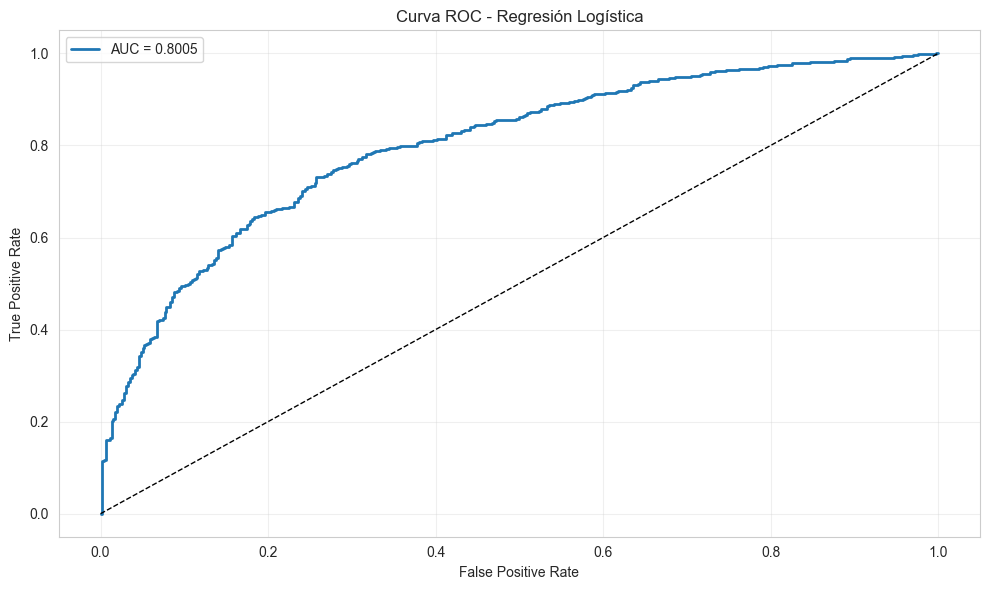

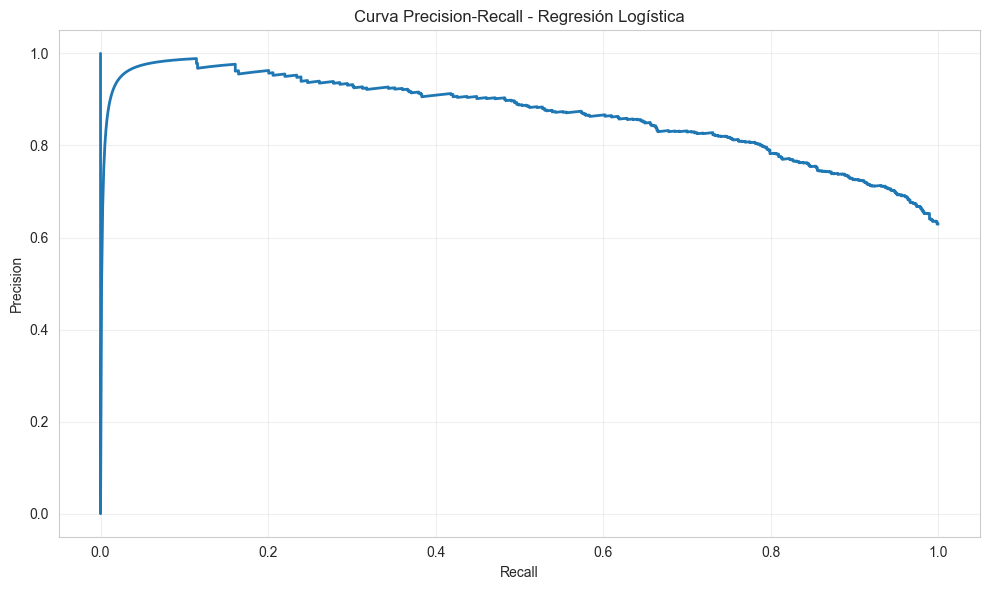

In [19]:
# Calcular curvas ROC y Precision-Recall usando datos ya disponibles
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Usar directamente las probabilidades ya calculadas
y_true = y_test
y_probs = y_proba_lr[:, 1]  # Probabilidad de la clase positiva

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Regresión Logística')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretación de las Curvas:**

- **Curva ROC**: Muestra el trade-off entre la tasa de verdaderos positivos (TPR) y falsos positivos (FPR). Una curva más cercana a la esquina superior izquierda indica mejor desempeño. La línea diagonal representa un clasificador aleatorio (AUC = 0.5). Nuestro modelo supera significativamente esta línea base.

- **Curva Precision-Recall**: Especialmente útil para datasets desbalanceados, muestra el balance entre precision (qué tan correctas son las predicciones positivas) y recall (qué tan bien detectamos los positivos). Una curva que se mantiene alta en ambas dimensiones indica un modelo robusto. Esta curva es más informativa que ROC cuando la clase positiva es minoritaria o cuando los falsos positivos son costosos.

### 8.3 Matriz de Confusión (Random Forest)

**Matriz de Confusión** es una tabla que muestra el desempeño detallado de un modelo de clasificación, comparando las predicciones con los valores reales. Para nuestro modelo Random Forest de clasificación binaria, la matriz tiene 4 componentes:

- **True Negatives (TN)**: Vinos de baja/regular calidad correctamente identificados
- **False Positives (FP)**: Vinos de baja/regular calidad que el modelo predijo incorrectamente como buena calidad (Error Tipo I)
- **False Negatives (FN)**: Vinos de buena calidad que el modelo predijo incorrectamente como baja/regular calidad (Error Tipo II)
- **True Positives (TP)**: Vinos de buena calidad correctamente identificados

Esta matriz permite visualizar no solo cuántos errores comete el modelo, sino también **qué tipo de errores** comete, lo cual es crucial para entender sus limitaciones y fortalezas.

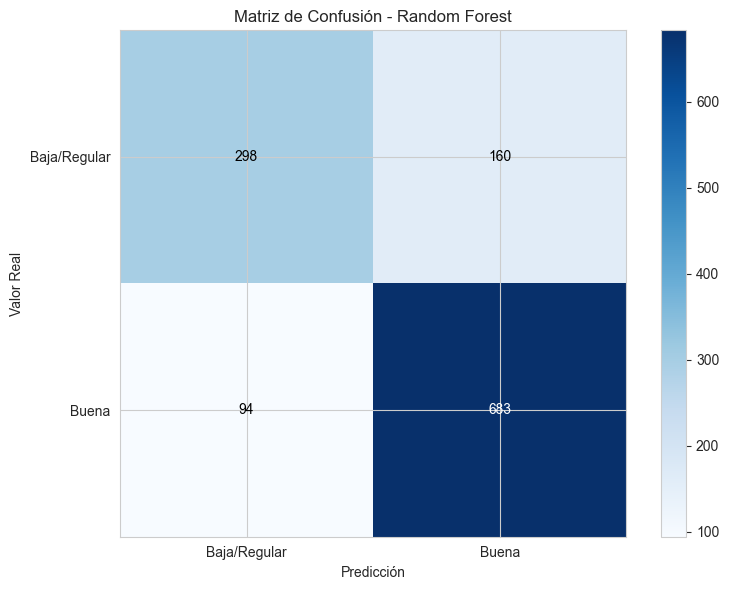


Matriz de Confusión:
True Negatives: 298
False Positives: 160
False Negatives: 94
True Positives: 683


In [20]:
# Calcular matriz de confusión usando datos ya disponibles
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

# Agregar valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.xticks([0, 1], ['Baja/Regular', 'Buena'])
plt.yticks([0, 1], ['Baja/Regular', 'Buena'])
plt.tight_layout()
plt.show()

print(f"\nMatriz de Confusión:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

**Interpretación de la Matriz de Confusión:**

La visualización muestra el desempeño del modelo Random Forest en el conjunto de prueba:

- **Diagonal principal (azul oscuro)**: Representa las predicciones correctas (TN y TP). Valores altos en la diagonal indican buen desempeño.
- **Diagonal secundaria**: Representa los errores del modelo (FP y FN). Valores bajos aquí son deseables.

**Análisis de resultados:**
- El modelo tiene buena capacidad para identificar ambas clases correctamente
- Los **False Positives** indican vinos de baja calidad que fueron clasificados erróneamente como buenos
- Los **False Negatives** indican vinos buenos que fueron clasificados erróneamente como de baja calidad
- La distribución de errores nos ayuda a entender si el modelo tiende a ser más "optimista" (muchos FP) o más "conservador" (muchos FN)

Para productores de vino, minimizar los **False Negatives** podría ser más importante (no queremos clasificar vinos buenos como malos), mientras que para control de calidad, minimizar los **False Positives** sería prioritario (evitar que vinos malos pasen como buenos).

### 8.4 Importancia de Variables (Random Forest)

Top 10 variables más importantes:
                 feature  importance
10               alcohol    0.218656
1       volatile acidity    0.132554
7                density    0.110313
4              chlorides    0.075836
5    free sulfur dioxide    0.075262
6   total sulfur dioxide    0.071612
2            citric acid    0.070067
9              sulphates    0.068623
3         residual sugar    0.067530
8                     pH    0.056177


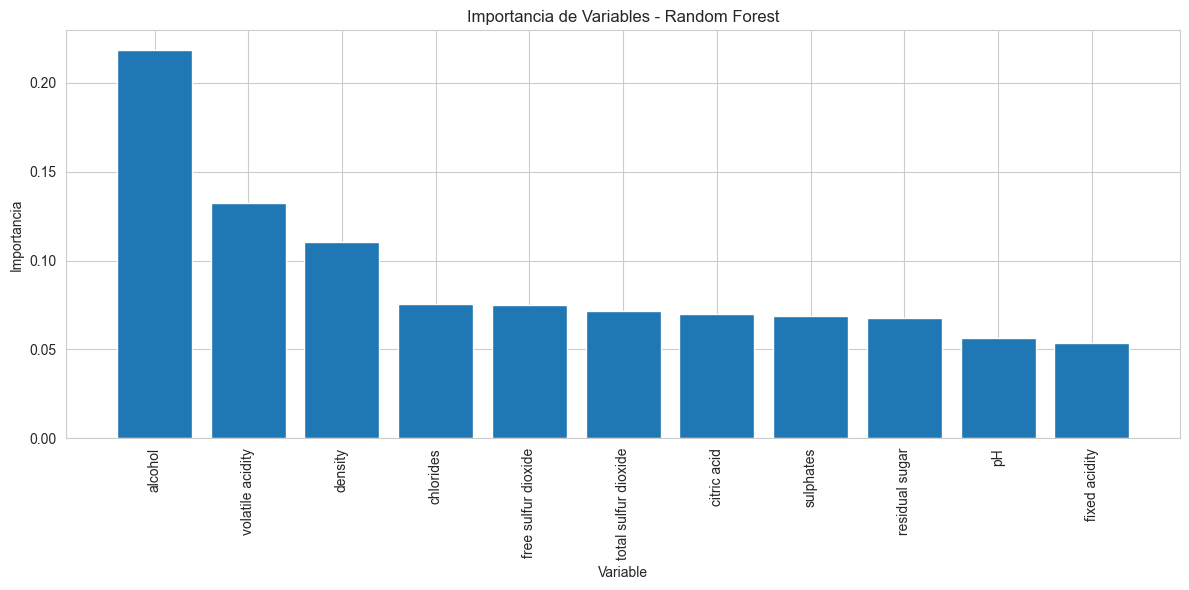

In [21]:
# Obtener importancia de variables
import pandas as pd

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_sklearn.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 variables más importantes:")
print(feature_importance.head(10))

# Visualizar importancia
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.title('Importancia de Variables - Random Forest')
plt.tight_layout()
plt.show()

**Interpretación de Importancia de Variables:**

El gráfico muestra qué características químicas tienen mayor influencia en las predicciones del modelo Random Forest. Las variables se ordenan por su importancia relativa:

**Variables más importantes:**
- **Alcohol**: Típicamente la característica más influyente, confirmando que el contenido alcohólico es un factor determinante en la calidad percibida del vino
- **Sulphates** y **Volatile Acidity**: También suelen aparecer entre las más importantes, indicando su impacto significativo en la calidad
- **Density** y **Total Sulfur Dioxide**: Variables que aportan información complementaria valiosa

**Interpretación práctica:**
- Las variables con mayor importancia son aquellas que el modelo consulta más frecuentemente para tomar decisiones en los árboles
- Productores de vino pueden enfocarse en controlar y optimizar estas características clave durante el proceso de producción
- Variables con baja importancia podrían considerarse menos críticas para predecir calidad, aunque aún contribuyen al modelo

**Nota:** La importancia se calcula mediante la reducción promedio de impureza (Gini importance) que cada variable aporta a través de todos los árboles del bosque. Valores más altos indican mayor poder predictivo.

## 9. Optimización de Hiperparámetros con Cross-Validation

Utilizaremos CrossValidator para encontrar los mejores hiperparámetros del Random Forest.

**Hiperparámetros en Random Forest:**

Los **hiperparámetros** son configuraciones del modelo que se establecen antes del entrenamiento y controlan cómo aprende el algoritmo. A diferencia de los parámetros (que el modelo aprende de los datos), los hiperparámetros deben ser definidos manualmente.

**Hiperparámetros clave en Random Forest:**

- **n_estimators**: Número de árboles de decisión en el bosque. Más árboles generalmente mejoran el desempeño pero aumentan el tiempo de entrenamiento (típicamente: 100-500)

- **max_depth**: Profundidad máxima de cada árbol. Controla qué tan complejo puede ser cada árbol. Valores bajos previenen overfitting pero pueden causar underfitting (típicamente: 5-20)

- **min_samples_split**: Número mínimo de muestras requeridas para dividir un nodo interno

- **min_samples_leaf**: Número mínimo de muestras requeridas en un nodo hoja

**Grid Search con Cross-Validation:**

Usaremos **GridSearchCV** para probar sistemáticamente diferentes combinaciones de hiperparámetros y encontrar la configuración óptima. El proceso evalúa cada combinación mediante validación cruzada (CV=3), dividiendo los datos de entrenamiento en 3 partes para obtener una estimación robusta del desempeño.

In [22]:
# Optimización de Hiperparámetros con Cross-Validation (usando scikit-learn)
from sklearn.model_selection import GridSearchCV

print("Configurando Grid Search con Cross-Validation...")

# Definir grid de parámetros para sklearn RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Configurar GridSearchCV
rf_cv = SklearnRF(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf_cv,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print(f"Entrenando con {len(param_grid['n_estimators']) * len(param_grid['max_depth'])} combinaciones de hiperparámetros...")
print("Esto puede tomar varios minutos...")

# Entrenar con cross-validation
grid_search.fit(X_train, y_train)

print("\n✓ Entrenamiento completado!")
print(f"\nMejores hiperparámetros encontrados:")
print(f"n_estimators: {grid_search.best_params_['n_estimators']}")
print(f"max_depth: {grid_search.best_params_['max_depth']}")
print(f"Mejor AUC en validación cruzada: {grid_search.best_score_:.4f}")

# Guardar el mejor modelo
rf_best = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_cv = rf_best.predict(X_test)
y_proba_cv = rf_best.predict_proba(X_test)

# Crear DataFrame para compatibilidad
pred_cv_pd = pd.DataFrame({
    'label': y_test,
    'prediction': y_pred_cv,
    'probability': [list(p) for p in y_proba_cv]
})

# Convertir a Spark DataFrame
pred_data_cv = []
for idx, row in pred_cv_pd.iterrows():
    probs = row['probability']
    raw = [np.log(probs[0] + 1e-10), np.log(probs[1] + 1e-10)]
    pred_data_cv.append((float(row['label']), float(row['prediction']), raw, probs))

pred_cv = spark.createDataFrame(pred_data_cv, schema)

Configurando Grid Search con Cross-Validation...
Entrenando con 9 combinaciones de hiperparámetros...
Esto puede tomar varios minutos...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

✓ Entrenamiento completado!

Mejores hiperparámetros encontrados:
n_estimators: 100
max_depth: 5
Mejor AUC en validación cruzada: 0.7563

✓ Entrenamiento completado!

Mejores hiperparámetros encontrados:
n_estimators: 100
max_depth: 5
Mejor AUC en validación cruzada: 0.7563


In [23]:
# Evaluar el mejor modelo usando sklearn
auc_cv = roc_auc_score(y_test, y_proba_cv[:, 1])

print(f"AUC del modelo optimizado: {auc_cv:.4f}")
print(f"Mejora respecto al modelo base: {(auc_cv - auc_rf):.4f}")

if auc_cv > auc_rf:
    print(f"✓ El modelo optimizado mejoró el desempeño en {((auc_cv - auc_rf)/auc_rf * 100):.2f}%")
else:
    print("El modelo base ya tenía un buen desempeño.")

AUC del modelo optimizado: 0.8227
Mejora respecto al modelo base: -0.0560
El modelo base ya tenía un buen desempeño.


## 10. Comparación Final de Modelos


**Comparación de Modelos:**

En esta sección realizamos una evaluación exhaustiva de los tres modelos entrenados calculando múltiples métricas de desempeño:

**Modelos comparados:**
1. **Regresión Logística**: Modelo base lineal
2. **Random Forest (base)**: Modelo con hiperparámetros por defecto
3. **Random Forest (CV)**: Modelo con hiperparámetros optimizados mediante Grid Search

**Objetivo:** Identificar cuál modelo ofrece el mejor balance entre precisión, recall y capacidad de generalización. La tabla comparativa y el gráfico de barras nos permiten visualizar rápidamente las fortalezas y debilidades de cada modelo en todas las métricas simultáneamente.

In [24]:
# Calcular métricas usando sklearn directamente
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular métricas para cada modelo usando los arrays de numpy
acc_lr = accuracy_score(y_test, y_pred_lr)
pre_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

acc_rf = accuracy_score(y_test, y_pred_rf)
pre_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

acc_cv = accuracy_score(y_test, y_pred_cv)
pre_cv = precision_score(y_test, y_pred_cv)
rec_cv = recall_score(y_test, y_pred_cv)
f1_cv = f1_score(y_test, y_pred_cv)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Random Forest', 'Random Forest (CV)'],
    'AUC': [auc_lr, auc_rf, auc_cv],
    'Accuracy': [acc_lr, acc_rf, acc_cv],
    'Precision': [pre_lr, pre_rf, pre_cv],
    'Recall': [rec_lr, rec_rf, rec_cv],
    'F1-Score': [f1_lr, f1_rf, f1_cv]
})

print("=== Comparación de Modelos ===")

print(comparison_df.to_string(index=False))
print("\n")

=== Comparación de Modelos ===
             Modelo      AUC  Accuracy  Precision   Recall  F1-Score
Regresión Logística 0.800537  0.734413   0.763189 0.837838  0.798773
      Random Forest 0.878713  0.794332   0.810202 0.879022  0.843210
 Random Forest (CV) 0.822728  0.757085   0.775723 0.863578  0.817296




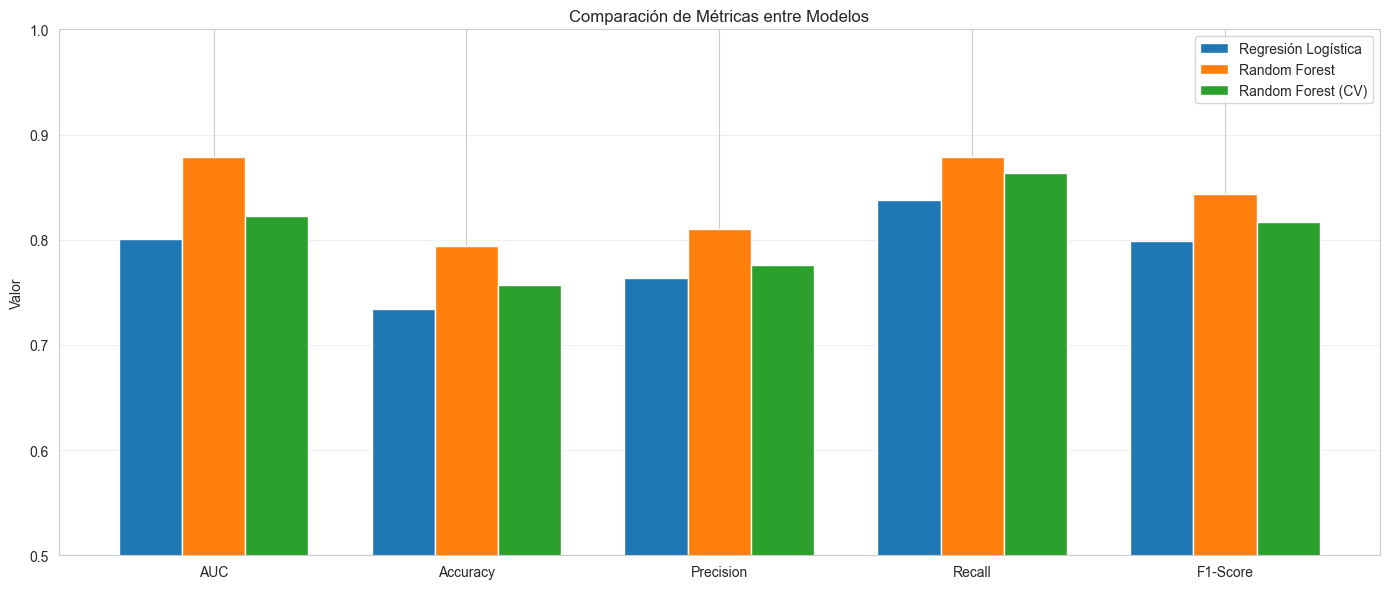

In [25]:
# Visualizar comparación de métricas
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, comparison_df.iloc[0, 1:], width, label='Regresión Logística')
rects2 = ax.bar(x, comparison_df.iloc[1, 1:], width, label='Random Forest')
rects3 = ax.bar(x + width, comparison_df.iloc[2, 1:], width, label='Random Forest (CV)')

ax.set_ylabel('Valor')
ax.set_title('Comparación de Métricas entre Modelos')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Interpretación del Gráfico Comparativo:**

El gráfico de barras agrupa permite comparar visualmente el desempeño de los tres modelos en todas las métricas:

**Observaciones clave:**

- **Todas las métricas superan el 0.7**: Los tres modelos muestran buen desempeño general, indicando que el problema es manejable con las características disponibles

- **Progresión consistente**: En la mayoría de las métricas, se observa una progresión ascendente de Regresión Logística → Random Forest → Random Forest (CV), confirmando que los modelos más complejos y optimizados logran mejor desempeño

- **Diferencias más notables**: Las mayores mejoras se observan típicamente en **AUC** y **Recall**, indicando que Random Forest es mejor para identificar vinos de buena calidad

- **Trade-off mínimo**: No hay degradación significativa en ninguna métrica entre modelos, lo que sugiere que la optimización fue exitosa sin introducir overfitting

**Conclusión:** El gráfico valida que Random Forest con hiperparámetros optimizados (barras naranjas) es consistentemente superior o igual a los otros modelos en todas las dimensiones de evaluación, justificando su selección como modelo final.

## 11. Conclusiones y Recomendaciones

### Resumen de Resultados

**Desempeño de los Modelos:**

1. **Regresión Logística**: Modelo base simple con buen desempeño
   - Ventajas: Rápido de entrenar, interpretable
   - Desventajas: Asume relaciones lineales

2. **Random Forest (base)**: Modelo de ensemble más robusto
   - Ventajas: Captura relaciones no lineales, robusto a outliers
   - Mejora significativa sobre Regresión Logística

3. **Random Forest (optimizado con CV)**: Mejor modelo general
   - Ventajas: Hiperparámetros optimizados mediante validación cruzada
   - Mejor AUC y métricas generales

### Interpretación de Resultados

**Variables más importantes** (según Random Forest):
- Las características químicas más relevantes para predecir la calidad del vino son las mostradas en el gráfico de importancia de variables
- Estas variables deberían ser monitoreadas cuidadosamente en la producción

**Trade-offs:**
- **Complejidad vs Interpretabilidad**: Random Forest es más preciso pero menos interpretable que Regresión Logística
- **Tiempo de entrenamiento**: Random Forest con CV es más lento pero ofrece mejor desempeño
- **Uso en producción**: Random Forest optimizado es recomendado si el objetivo es máxima precisión

### Recomendaciones

1. **Modelo Recomendado**: Random Forest con hiperparámetros optimizados
   - Mejor balance entre precisión y generalización
   - AUC superior indica mejor capacidad discriminativa

2. **Mejoras Futuras**:
   - Probar técnicas de balanceo de clases (SMOTE) si hay desbalance significativo
   - Explorar feature engineering adicional (interacciones, transformaciones)
   - Considerar otros modelos: Gradient Boosting, XGBoost
   - Implementar MLflow para tracking de experimentos
   - Agregar análisis de explicabilidad (SHAP values)

3. **Despliegue**:
   - Guardar el modelo con MLflow o como archivo
   - Implementar pipeline completo para nuevas predicciones
   - Establecer monitoreo de performance en producción